# Sinulator

## 1. Setup & Imports

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import date, timedelta
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

## 2. Pop Params

Metro cities and 2026 populations are extracted directly from the file. Country growth rates are applied to project forward. Non-metro population = country overall − sum of metro cities.

In [19]:
import openpyxl

wb = openpyxl.load_workbook('1.1_Ty.xlsx', data_only=True)
country_sheet = wb['Country']
city_sheet = wb['City']

metro_rows = []
country_stats = {}

# Extract country statistics
for row in country_sheet.iter_rows(min_row=2, values_only=True):
    stat_country, metro_stat, nonmetro_stat, overall_stat, gr = row[0], row[1], row[2], row[3], row[4]
    if isinstance(stat_country, str) and isinstance(overall_stat, (int, float)) and gr is not None:
        country_stats[stat_country] = {
            'metro_pop_2026': metro_stat,
            'nonmetro_pop_2026': nonmetro_stat,
            'overall_pop_2026': overall_stat,
            'growth_rate': gr
        }

# Extract metro cities
current_country = None
for row in city_sheet.iter_rows(values_only=True):
    country_col, city_col, pop_col = row[0], row[1], row[2]
    if isinstance(country_col, str):
        current_country = country_col
    if current_country and isinstance(city_col, str) and isinstance(pop_col, (int, float)):
        metro_rows.append({'Country': current_country, 'City': city_col, 'Pop_2026': int(pop_col)})

metro_df = pd.DataFrame(metro_rows)
country_stats_df = pd.DataFrame(country_stats).T.reset_index().rename(columns={'index': 'Country'})
country_stats_df[['metro_pop_2026', 'nonmetro_pop_2026', 'overall_pop_2026', 'growth_rate']] = \
    country_stats_df[['metro_pop_2026', 'nonmetro_pop_2026', 'overall_pop_2026', 'growth_rate']].apply(pd.to_numeric)

In [20]:
# Project populations 2027-2034
YEARS = list(range(2027, 2035))

# Metro projections
metro_df = metro_df.merge(country_stats_df[['Country', 'growth_rate']], on='Country', how='left')
for yr in YEARS:
    n = yr - 2026
    metro_df[f'Pop_{yr}'] = (metro_df['Pop_2026'] * (1 + metro_df['growth_rate'])**n).round(0).astype(int)

# Non-metro projections
metro_sum = metro_df.groupby('Country')[[f'Pop_{yr}' for yr in YEARS]].sum().reset_index()
metro_sum = metro_sum.rename(columns={f'Pop_{yr}': f'MetroSum_{yr}' for yr in YEARS})

nonmetro_df = country_stats_df.copy()
for yr in YEARS:
    n = yr - 2026
    nonmetro_df[f'OverallPop_{yr}'] = (nonmetro_df['overall_pop_2026'] * (1 + nonmetro_df['growth_rate'])**n).round(0)

nonmetro_df = nonmetro_df.merge(metro_sum, on='Country', how='left')
for yr in YEARS:
    nonmetro_df[f'NonMetroPop_{yr}'] = (nonmetro_df[f'OverallPop_{yr}'] - nonmetro_df[f'MetroSum_{yr}']).clip(lower=0).round(0)

print('Metro (first 5):')
print(metro_df[['Country', 'City', 'Pop_2026', 'Pop_2027', 'Pop_2028']].head())
print('\nNon-Metro (first 5):')
print(nonmetro_df[['Country', 'NonMetroPop_2027', 'NonMetroPop_2028']].head())

Metro (first 5):
   Country       City  Pop_2026  Pop_2027  Pop_2028
0  Belgium   Brussels   2150320   2153330   2156345
1  Belgium    Antwerp   1068660   1070156   1071654
2  Belgium      Liege    690769    691736    692705
3  Belgium       Gent    480931    481604    482279
4  Belgium  Charleroi    420510    421099    421688

Non-Metro (first 5):
       Country  NonMetroPop_2027  NonMetroPop_2028
0      Belgium         6973159.0         6982921.0
1      Germany        58518166.0        58219725.0
2  Netherlands        14010356.0        14210705.0
3      Denmark         4400797.0         4425440.0
4      Estonia          875401.0          878464.0


## 3. Demand Parameters 

In [21]:
# Market entry years
ENTRY_YEAR = {
    'Belgium': 2027, 'Germany': 2027, 'Luxembourg': 2027, 'Netherlands': 2027,
    'Denmark': 2028, 'Estonia': 2028, 'Finland': 2028, 'Latvia': 2028,
    'Lithuania': 2028, 'Norway': 2028, 'Poland': 2028, 'Sweden': 2028,
    'Austria': 2029, 'France': 2029, 'Ireland': 2029, 'Italy': 2029,
    'Portugal': 2029, 'Spain': 2029, 'Switzerland': 2029,
    'Bulgaria': 2030, 'Croatia': 2030, 'Cyprus': 2030, 'Czech Republic': 2030,
    'Greece': 2030, 'Hungary': 2030, 'Malta': 2030, 'Romania': 2030,
    'Slovakia': 2030, 'Slovenia': 2030
}

# Adoption rate functions (triangular basis)
def adoption_rate_mp(market_year: int) -> float:
    if market_year <= 0: return 0.0
    base = 0.00025
    if market_year == 1: return base
    base += 0.0002
    if market_year == 2: return base
    base += 0.0001
    if market_year == 3: return base
    return base + (market_year - 3) * 0.00005

def adoption_rate_opt(market_year: int) -> float:
    if market_year <= 0: return 0.0
    base = 0.0005
    if market_year == 1: return base
    base += 0.00025
    if market_year == 2: return base
    base += 0.0002
    if market_year == 3: return base
    return base + (market_year - 3) * 0.0001

def adoption_rate_pes(market_year: int) -> float:
    if market_year <= 0: return 0.0
    base = 0.0002
    if market_year == 1: return base
    base += 0.0001
    if market_year == 2: return base
    base += 0.00005
    if market_year == 3: return base
    return max(0, base + (market_year - 3) * (-0.00002))

# Day-of-week and period parameters
DOW_WEIGHTS = np.array([0.12, 0.12, 0.23, 0.25, 0.15, 0.10, 0.03])  # Mon-Sun
PERIOD_SHARES_BASE = np.array([0.05, 0.07, 0.09, 0.09, 0.09, 0.05, 0.04,
                                0.06, 0.13, 0.09, 0.06, 0.07, 0.11])
PERIOD_CV = 0.25
CYBER_WEEK_SHARE = 0.15
CYBER_PRICE_DISCOUNT = 0.15

In [22]:
# MyBot models
MODELS = [
    ('F10', 'Floor Care', 10, 360, 0.17),
    ('K10', 'Kitchen Help', 10, 360, 0.13),
    ('S10', 'Safety & Security', 10, 360, 0.10),
    ('W10', 'Wall & Window', 10, 360, 0.09),
    ('F20', 'Floor Care', 20, 480, 0.08),
    ('K20', 'Kitchen Help', 20, 480, 0.06),
    ('L20', 'Leisure', 20, 480, 0.05),
    ('S20', 'Safety & Security', 20, 480, 0.05),
    ('W20', 'Wall & Window', 20, 480, 0.04),
    ('X20', 'Exterior Care', 20, 480, 0.04),
    ('F30', 'Floor Care', 30, 600, 0.04),
    ('K30', 'Kitchen Help', 30, 600, 0.03),
    ('L30', 'Leisure', 30, 600, 0.03),
    ('S30', 'Safety & Security', 30, 600, 0.03),
    ('W30', 'Wall & Window', 30, 600, 0.02),
    ('X30', 'Exterior Care', 30, 600, 0.02),
    ('F50', 'Floor Care', 50, 720, 0.02),
    ('K50', 'Kitchen Help', 50, 720, 0.02),
    ('L50', 'Leisure', 50, 720, 0.01),
    ('S50', 'Safety & Security', 50, 720, 0.01),
    ('W50', 'Wall & Window', 50, 720, 0.01),
    ('X50', 'Exterior Care', 50, 720, 0.01),
    ('L10', 'Leisure', 10, 360, 0.02),
    ('X10', 'Exterior Care', 10, 360, 0.02),
]

model_df = pd.DataFrame(MODELS, columns=['Model', 'Category', 'Level', 'Price_EUR', 'Share_MP'])
model_df['Share_MP'] = model_df['Share_MP'] / model_df['Share_MP'].sum()

## 4. Calendar Builder

In [23]:
def first_monday_of_year(year: int) -> date:
    d = date(year, 1, 1)
    days_ahead = (7 - d.weekday()) % 7
    if days_ahead == 0:
        return d
    return d + timedelta(days=days_ahead) # add a date to move the date on calendar forwards

def black_friday(year: int) -> date:
    nov1 = date(year, 11, 1)
    days_to_friday = (4 - nov1.weekday()) % 7
    first_fri = nov1 + timedelta(days=days_to_friday)
    return first_fri + timedelta(weeks=3)

def cyber_week_dates(year: int):
    bf = black_friday(year)
    return {bf + timedelta(days=d) for d in range(4)}

def build_year_calendar(year: int) -> pd.DataFrame:
    start = date(year, 1, 1)
    end = date(year, 12, 31)
    days = [start + timedelta(days=i) for i in range((end - start).days + 1)]
    
    period_start = first_monday_of_year(year)
    cw = cyber_week_dates(year)
    
    records = []
    for d in days:
        delta = (d - period_start).days
        if delta >= 0:
            period = delta // 28 + 1
            period = min(period, 13)
        else:
            period = 1
        records.append({
            'date': d,
            'year': year,
            'day_of_week': d.weekday(),
            'period': period,
            'is_cyber_week': d in cw # returns boolean variable
        })
    return pd.DataFrame(records)


## 5. OTD Probability Table & Conversion Functions

In [24]:
# OTD probability lookup table 
OTD_PROB_TABLE = {
    'Metro': [
        (0, 0, 1.00),      
        (1, 1, 0.95),     
        (2, 2, 0.85),     
        (3, 4, 0.65),      
        (5, 7, 0.40),     
        (8, 15, 0.20),    
        (16, 30, 0.10),    
        (31, 60, 0.05),    
    ],
    'Non-Metro': [
        (0, 0, 1.00),
        (1, 1, 0.995),
        (2, 2, 0.98),
        (3, 4, 0.90),
        (5, 7, 0.70),
        (8, 15, 0.30),
        (16, 30, 0.15),
        (31, 60, 0.075),
    ]
}

def get_otd_conversion_rate(segment: str, otd_days: float) -> float:
    """Get conversion rate using interval-based lookup with interpolation."""
    table = OTD_PROB_TABLE[segment]
    
    # Find matching interval
    for min_days, max_days, conv_rate in table:
        if min_days <= otd_days <= max_days:
            return conv_rate
    
    # Out of range cases
    if otd_days < table[0][0]:
        return table[0][2]
    if otd_days > table[-1][1]:
        return table[-1][2]
    
    # Between intervals: interpolate
    for i in range(len(table) - 1):
        min1, max1, rate1 = table[i]
        min2, max2, rate2 = table[i + 1]
        mid1 = (min1 + max1) / 2.0
        mid2 = (min2 + max2) / 2.0
        if max1 < otd_days < min2:
            t = (otd_days - mid1) / (mid2 - mid1)
            return rate1 + t * (rate2 - rate1)
    
    return 0.0

print('Interval-based OTD table loaded')
print(f'Metro 2-day: {get_otd_conversion_rate("Metro", 2):.1%}')
print(f'Non-Metro 5-day: {get_otd_conversion_rate("Non-Metro", 5):.1%}')

Interval-based OTD table loaded
Metro 2-day: 85.0%
Non-Metro 5-day: 70.0%


## 6. Stochastic Number Generation Function

In [25]:
def triangular_adoption_rate(market_year: int, sim: int, yr: int) -> float:
    """
    Draw annual adoption rate from Triangular distribution.
    Fresh seed per (year, sim) for independent draws.
    """
    a = adoption_rate_pes(market_year)
    c = adoption_rate_mp(market_year)
    b = adoption_rate_opt(market_year)
    
    if a >= b:
        return c
    c = np.clip(c, a + 1e-12, b - 1e-12)
    
    seed = int(yr) * 100_000 + int(sim) * 13
    rng = np.random.default_rng(seed)
    return float(rng.triangular(left=a, mode=c, right=b))

def triangular_model_shares(model_shares_base: np.ndarray, sim: int, yr: int, spread: float = 0.20) -> np.ndarray:
    """
    Draw 24-model share vector from Triangular distribution.
    Renormalized to sum=1.
    """
    a = model_shares_base * (1.0 - spread)
    c = model_shares_base
    b = model_shares_base * (1.0 + spread)
    
    seed = int(yr) * 100_000 + int(sim) * 13 + 7
    rng = np.random.default_rng(seed)
    
    draws = rng.triangular(left=a, mode=c, right=b)
    draws = np.clip(draws, 1e-9, None)
    return draws / draws.sum()

def simulate_period_shares(n_sim: int = 1, seed: int = None) -> np.ndarray:
    """
    Draw period shares from Normal(base, CV*base).
    Returns shape (n_sim, 13).
    """
    rng = np.random.default_rng(seed)
    mu = PERIOD_SHARES_BASE
    std = PERIOD_CV * mu
    draws = rng.normal(loc=mu, scale=std, size=(n_sim, 13))
    draws = np.clip(draws, 1e-6, None)
    return draws / draws.sum(axis=1, keepdims=True)

## 7. Core Simulator — Aggregate Demand with OTD Conversion

### Modified pipeline:
1. Compute annual demand by segment (metro/non-metro) using triangular adoption rates
2. Allocate to daily **aggregate demand** by segment, day, and Cyber Week status
3. **Apply OTD conversion** at aggregate level for all product lines in daily basis → **CV sales**
4. Decompose aggregate sales to 24 products using triangular model shares

This avoids the explosion in output size from applying conversion at product level.

In [26]:
def run_otd_simulator(
    metro_df: pd.DataFrame,
    nonmetro_df: pd.DataFrame,
    model_df: pd.DataFrame,
    entry_year_map: dict,
    years: list,
    metro_city_otd: dict,  # City-level OTD by year: {city_name: {year: otd_days}}
    nonmetro_otd: dict,    # Country-level OTD by year: {country: {year: otd_days}}
    n_sim: int = 1,
    seed: int = 42
) -> pd.DataFrame:
    """
    Run OTD simulator with YEAR-SPECIFIC CITY-LEVEL metro OTD specification.
    
    Args:
        metro_city_otd: Dict mapping city names to year-specific OTD days
                       (e.g., {'Brussels': {2027: 1.0, 2028: 0.97, ...}})
        nonmetro_otd: Dict mapping country names to year-specific OTD days
                     (e.g., {'Belgium': {2027: 5.0, 2028: 4.85, ...}})
    """
    rng_global = np.random.default_rng(seed)
    model_shares_base = model_df['Share_MP'].values
    model_codes = model_df['Model'].values
    model_prices = model_df['Price_EUR'].values
    
    sim_records = []
    
    for sim in range(n_sim):
        print(f'  Sim {sim+1}/{n_sim}...', end=' ', flush=True)
        
        for yr in years:
            cal = build_year_calendar(yr)
            cw_days = cal[cal['is_cyber_week']]['date'].values
            ncw_days = cal[~cal['is_cyber_week']]
            n_cw = len(cw_days)
            
            # ── 1. Compute annual demand AGGREGATED BY COUNTRY-SEGMENT ──
            segment_annual = {}
            
            # Metro cities - aggregate to country level
            for _, city_row in metro_df.iterrows():
                country = city_row['Country']
                if country not in entry_year_map:
                    continue
                entry = entry_year_map[country]
                market_year = yr - entry + 1
                if market_year < 1:
                    continue
                
                pop = city_row[f'Pop_{yr}']
                rate = triangular_adoption_rate(market_year, sim, yr)
                units = pop * rate
                
                key = (country, 'Metro')
                segment_annual[key] = segment_annual.get(key, 0) + units
            
            # Non-metro
            for _, nm_row in nonmetro_df.iterrows():
                country = nm_row['Country']
                if country not in entry_year_map:
                    continue
                entry = entry_year_map[country]
                market_year = yr - entry + 1
                if market_year < 1:
                    continue
                
                pop = nm_row[f'NonMetroPop_{yr}']
                rate = triangular_adoption_rate(market_year, sim, yr)
                units = pop * rate
                
                key = (country, 'Non-Metro')
                segment_annual[key] = units
            
            if len(segment_annual) == 0:
                continue
            
            total_annual = sum(segment_annual.values())
            if total_annual == 0:
                continue
            
            # ── 2. Draw period shares ──
            period_shares = simulate_period_shares(n_sim=1, seed=int(rng_global.integers(0, 1_000_000)))[0]
            
            # ── 3. Split: Cyber Week vs regular ──
            cyber_total = total_annual * CYBER_WEEK_SHARE
            regular_total = total_annual * (1.0 - CYBER_WEEK_SHARE)
            
            # ── 4. Allocate regular demand → period → day ──
            day_demand_total = {}
            for p in range(1, 14):
                period_units = regular_total * period_shares[p - 1]
                p_days = ncw_days[ncw_days['period'] == p]
                if len(p_days) == 0:
                    continue
                dow_w = p_days['day_of_week'].map(lambda d: DOW_WEIGHTS[d]).values
                dow_w = dow_w / dow_w.sum()
                for d_idx, (_, day_row) in enumerate(p_days.iterrows()):
                    day_demand_total[day_row['date']] = period_units * dow_w[d_idx]
            
            # ── 5. Allocate Cyber Week demand ──
            if n_cw > 0:
                cw_cal = cal[cal['is_cyber_week']]
                cw_dow_w = cw_cal['day_of_week'].map(lambda d: DOW_WEIGHTS[d]).values
                cw_dow_w = cw_dow_w / cw_dow_w.sum()
                for i, (_, cw_row) in enumerate(cw_cal.iterrows()):
                    day_demand_total[cw_row['date']] = cyber_total * cw_dow_w[i]
            
            # ── 6. Distribute daily demand to country-segments ──
            segment_weights = {k: v/total_annual for k, v in segment_annual.items()}
            cw_date_set = {pd.Timestamp(x).date() if not isinstance(x, date) else x for x in cw_days}
            
            # ── 7. Pre-compute country-level metro OTD for THIS YEAR (population-weighted) ──
            country_metro_otd_yr = {}
            for _, city_row in metro_df.iterrows():
                country = city_row['Country']
                city = city_row['City']
                pop = city_row[f'Pop_{yr}']
                
                # Get YEAR-SPECIFIC OTD for this city
                if city in metro_city_otd and yr in metro_city_otd[city]:
                    city_otd = metro_city_otd[city][yr]
                else:
                    city_otd = 2.0  # Default fallback
                
                if country not in country_metro_otd_yr:
                    country_metro_otd_yr[country] = {'weighted_sum': 0.0, 'total_pop': 0.0}
                
                country_metro_otd_yr[country]['weighted_sum'] += city_otd * pop
                country_metro_otd_yr[country]['total_pop'] += pop
            
            # Compute weighted average
            for country in country_metro_otd_yr:
                if country_metro_otd_yr[country]['total_pop'] > 0:
                    country_metro_otd_yr[country] = (
                        country_metro_otd_yr[country]['weighted_sum'] / 
                        country_metro_otd_yr[country]['total_pop']
                    )
                else:
                    country_metro_otd_yr[country] = 2.0
            
            # ── 8. Apply OTD conversion at aggregate level ──
            daily_segment_sales = {}
            
            for d, total_units in day_demand_total.items():
                is_cw = d in cw_date_set
                
                for (country, segment), seg_weight in segment_weights.items():
                    seg_demand = total_units * seg_weight
                    
                    # Get YEAR-SPECIFIC OTD for this country-segment
                    if segment == 'Metro':
                        otd_days = country_metro_otd_yr.get(country, 2.0)
                    else:
                        # Get year-specific non-metro OTD
                        if country in nonmetro_otd and yr in nonmetro_otd[country]:
                            otd_days = nonmetro_otd[country][yr]
                        else:
                            otd_days = 5.0  # Default fallback
                    
                    # Apply OTD conversion
                    conversion_rate = get_otd_conversion_rate(segment, otd_days)
                    seg_sales = seg_demand * conversion_rate
                    
                    daily_segment_sales[(d, country, segment, is_cw)] = {
                        'demand': seg_demand,
                        'sales': seg_sales,
                        'otd_days': otd_days,
                        'conversion_rate': conversion_rate
                    }
            
            # ── 9. Decompose aggregate sales to 24 products ──
            model_shares = triangular_model_shares(model_shares_base, sim, yr)
            
            for (d, country, segment, is_cw), agg_data in daily_segment_sales.items():
                sales_agg = agg_data['sales']
                demand_agg = agg_data['demand']
                
                model_sales = sales_agg * model_shares
                model_demand = demand_agg * model_shares
                
                price_factor = (1.0 - CYBER_PRICE_DISCOUNT) if is_cw else 1.0
                
                for m_idx, mdl in enumerate(model_codes):
                    ms = model_sales[m_idx]
                    if ms < 1e-9:
                        continue
                    
                    sim_records.append({
                        'sim': sim,
                        'date': pd.Timestamp(d),
                        'year': yr,
                        'country': country,
                        'segment': segment,
                        'is_cyber_week': is_cw,
                        'demand_units': model_demand[m_idx],
                        'otd_days': agg_data['otd_days'],
                        'conversion_rate': agg_data['conversion_rate'],
                        'sales_units': ms,
                        'model': mdl,
                        'revenue': ms * model_prices[m_idx] * price_factor
                    })
        
        print(f'Done')
    
    return pd.DataFrame(sim_records)

## 8. City OTD Params Retrieval

Load OTD data from assignment CSV file with year-specific values

In [27]:
# ==================== LOAD OTD DATA FROM CSV ====================
# Load the assignment data with OTD values
otd_data = pd.read_csv('assignment_with_otd_prob_reachable.csv')

print(f'Loaded OTD data: {len(otd_data)} rows')
print(f'Years covered: {sorted(otd_data["year"].unique())}')
print(f'Node types: {otd_data["node_type"].value_counts().to_dict()}')

# Country code mapping (ISO 2-letter to full name)
COUNTRY_CODE_MAP = {
    'AT': 'Austria', 'BE': 'Belgium', 'BG': 'Bulgaria', 'CH': 'Switzerland',
    'CY': 'Cyprus', 'CZ': 'Czech Republic', 'DE': 'Germany', 'DK': 'Denmark',
    'EE': 'Estonia', 'ES': 'Spain', 'FI': 'Finland', 'FR': 'France',
    'GR': 'Greece', 'HR': 'Croatia', 'HU': 'Hungary', 'IE': 'Ireland',
    'IT': 'Italy', 'LT': 'Lithuania', 'LU': 'Luxembourg', 'LV': 'Latvia',
    'MT': 'Malta', 'NL': 'Netherlands', 'NO': 'Norway', 'PL': 'Poland',
    'PT': 'Portugal', 'RO': 'Romania', 'SE': 'Sweden', 'SI': 'Slovenia',
    'SK': 'Slovakia'
}

# Helper function to normalize city names (CSV format -> DataFrame format)
def normalize_city_name(csv_city_name):
    """
    Convert CSV city name format (e.g., 'frankfurt_am_main') 
    to DataFrame format (e.g., 'Frankfurt am Main')
    """
    # Split by underscore and title case each word
    words = csv_city_name.split('_')
    # Title case each word
    titled_words = [w.title() for w in words]
    return ' '.join(titled_words)

# Build metro_city_otd dictionary: {city_name: {year: otd_days}}
metro_city_otd = {}
metro_otd_df = otd_data[otd_data['node_type'] == 'metro'].copy()

for _, row in metro_otd_df.iterrows():
    # Parse node_id: "METRO_BE_brussels" -> country_code="BE", city="brussels"
    parts = row['node_id'].split('_')
    if len(parts) >= 3:
        country_code = parts[1]
        csv_city_name = '_'.join(parts[2:])  # Handle multi-word cities
        
        # Normalize city name to match metro_df format
        city_name = normalize_city_name(csv_city_name)
        
        year = int(row['year'])
        otd_days = float(row['otd_days_promise'])
        
        # Initialize city dict if needed
        if city_name not in metro_city_otd:
            metro_city_otd[city_name] = {}
        
        metro_city_otd[city_name][year] = otd_days

# Build country_nonmetro_otd dictionary: {country_name: {year: otd_days}}
country_nonmetro_otd = {}
nonmetro_otd_df = otd_data[otd_data['node_type'] == 'non_metro'].copy()

for _, row in nonmetro_otd_df.iterrows():
    # Parse node_id: "NONMETRO_BE" -> country_code="BE"
    parts = row['node_id'].split('_')
    if len(parts) >= 2:
        country_code = parts[1]
        
        # Map country code to full name
        country_name = COUNTRY_CODE_MAP.get(country_code, country_code)
        
        year = int(row['year'])
        otd_days = float(row['otd_days_promise'])
        
        # Initialize country dict if needed
        if country_name not in country_nonmetro_otd:
            country_nonmetro_otd[country_name] = {}
        
        country_nonmetro_otd[country_name][year] = otd_days

print(f'\nLoaded OTD for {len(metro_city_otd)} metro cities')
print(f'Loaded OTD for {len(country_nonmetro_otd)} non-metro countries')

# ==================== VALIDATION ====================
# 1. Check match with entry map
print('\n=== VALIDATION 1: Country Coverage ===')
countries_in_entry_map = set(ENTRY_YEAR.keys())
countries_with_nonmetro_otd = set(country_nonmetro_otd.keys())

missing_in_otd = countries_in_entry_map - countries_with_nonmetro_otd
extra_in_otd = countries_with_nonmetro_otd - countries_in_entry_map

if missing_in_otd:
    print(f'⚠️  Countries in ENTRY_YEAR but missing non-metro OTD: {missing_in_otd}')
else:
    print('✓ All countries in ENTRY_YEAR have non-metro OTD data')

if extra_in_otd:
    print(f'ℹ️  Extra countries with non-metro OTD (not in ENTRY_YEAR): {extra_in_otd}')

# 2. Check metro city matching
print('\n=== VALIDATION 2: Metro City Coverage ===')
cities_in_metro_df = set(metro_df['City'].unique())
cities_with_otd = set(metro_city_otd.keys())

missing_cities = cities_in_metro_df - cities_with_otd
extra_cities = cities_with_otd - cities_in_metro_df

print(f'Cities in metro_df: {len(cities_in_metro_df)}')
print(f'Cities with OTD data: {len(cities_with_otd)}')

if missing_cities:
    print(f'⚠️  Cities in metro_df missing OTD ({len(missing_cities)}): {list(missing_cities)[:10]}...')
else:
    print('✓ All cities in metro_df have OTD data')

if extra_cities:
    print(f'ℹ️  Extra cities with OTD not in metro_df ({len(extra_cities)}): {list(extra_cities)[:10]}...')

# 3. Check year coverage
print('\n=== VALIDATION 3: Year Coverage ===')
years_expected = set(YEARS)
years_in_otd = set()
for city_dict in metro_city_otd.values():
    years_in_otd.update(city_dict.keys())

if years_in_otd == years_expected:
    print(f'✓ OTD data covers all expected years: {sorted(years_expected)}')
else:
    missing_years = years_expected - years_in_otd
    extra_years = years_in_otd - years_expected
    if missing_years:
        print(f'⚠️  Missing years in OTD: {missing_years}')
    if extra_years:
        print(f'ℹ️  Extra years in OTD: {extra_years}')

# 4. Show sample OTD values
print('\n=== SAMPLE OTD VALUES ===')
sample_cities = list(metro_city_otd.keys())[:5]
for city in sample_cities:
    print(f'\n{city}:')
    for yr in [2027, 2030, 2034]:
        if yr in metro_city_otd[city]:
            print(f'  {yr}: {metro_city_otd[city][yr]:.2f} days')

sample_countries = list(country_nonmetro_otd.keys())[:3]
print('\nNon-Metro Countries:')
for country in sample_countries:
    print(f'\n{country}:')
    for yr in [2027, 2030, 2034]:
        if yr in country_nonmetro_otd[country]:
            print(f'  {yr}: {country_nonmetro_otd[country][yr]:.2f} days')

# 5. Statistics
print('\n=== OTD STATISTICS ===')
all_metro_otd = [v for city_dict in metro_city_otd.values() for v in city_dict.values()]
all_nonmetro_otd = [v for country_dict in country_nonmetro_otd.values() for v in country_dict.values()]

if all_metro_otd:
    print(f'Metro OTD: min={min(all_metro_otd):.2f}, max={max(all_metro_otd):.2f}, mean={sum(all_metro_otd)/len(all_metro_otd):.2f} days')
if all_nonmetro_otd:
    print(f'Non-Metro OTD: min={min(all_nonmetro_otd):.2f}, max={max(all_nonmetro_otd):.2f}, mean={sum(all_nonmetro_otd)/len(all_nonmetro_otd):.2f} days')


# ==================== ORIGINAL SYNTHETIC CODE (COMMENTED OUT) ====================
# # Generate city-level OTD for ALL 273 metro cities - YEAR-SPECIFIC (2027-2034)
# 
# # Structure: metro_city_otd[city][year] = otd_days
# # Structure: country_nonmetro_otd[country][year] = otd_days
# 
# metro_city_otd = {}
# country_nonmetro_otd = {}
# 
# # Base OTD assignment by population tier (for 2027)
# for _, row in metro_df.iterrows():
#     city = row['City']
#     pop = row['Pop_2026']
#     
#     # Assign base OTD based on population tiers
#     if pop >= 2_000_000:        # Very large cities
#         base_otd = 1.0
#     elif pop >= 1_000_000:      # Large cities
#         base_otd = 1.5
#     elif pop >= 500_000:        # Medium cities
#         base_otd = 2.0
#     elif pop >= 250_000:        # Small cities
#         base_otd = 2.5
#     else:                       # Very small metro cities
#         base_otd = 3.0
#     
#     # Generate year-specific OTD (improving over time)
#     # Assume logistics infrastructure improves: 3% reduction per year
#     metro_city_otd[city] = {}
#     for idx, yr in enumerate(YEARS):
#         improvement_factor = 0.97 ** idx  # 3% improvement per year
#         metro_city_otd[city][yr] = max(0.5, base_otd * improvement_factor)  # Floor at 0.5 days
# 
# # Generate country-level non-metro OTD by year
# rng1 = np.random.default_rng(42)  # Fixed seed for reproducibility
# 
# for country in nonmetro_df['Country'].unique():
#     base_nonmetro_otd = rng1.uniform(3.0, 6.0)  # Base OTD between 3-6 days
#     
#     country_nonmetro_otd[country] = {}
#     for idx, yr in enumerate(YEARS):
#         improvement_factor = 0.97 ** idx  # Same 3% improvement per year
#         country_nonmetro_otd[country][yr] = max(1.0, base_nonmetro_otd * improvement_factor)  # Floor at 1.0 day
# 
# print(f'Generated year-specific city-level OTD for {len(metro_city_otd)} metro cities')
# print(f'Generated year-specific country non-metro OTD for {len(country_nonmetro_otd)} countries')
# 
# # Show OTD evolution for sample cities
# print(f'\nSample Metro City OTD Evolution:')
# sample_cities = list(metro_city_otd.keys())[:5]
# for city in sample_cities:
#     print(f'  {city}:')
#     for yr in [2027, 2030, 2034]:
#         print(f'    {yr}: {metro_city_otd[city][yr]:.2f} days')
# 
# print(f'\nSample Non-Metro Country OTD Evolution:')
# sample_countries = list(country_nonmetro_otd.keys())[:3]
# for country in sample_countries:
#     print(f'  {country}:')
#     for yr in [2027, 2030, 2034]:
#         print(f'    {yr}: {country_nonmetro_otd[country][yr]:.2f} days')

Loaded OTD data: 1966 rows
Years covered: [np.int64(2027), np.int64(2028), np.int64(2029), np.int64(2030), np.int64(2031), np.int64(2032), np.int64(2033), np.int64(2034)]
Node types: {'metro': 1786, 'non_metro': 180}

Loaded OTD for 272 metro cities
Loaded OTD for 29 non-metro countries

=== VALIDATION 1: Country Coverage ===
✓ All countries in ENTRY_YEAR have non-metro OTD data

=== VALIDATION 2: Metro City Coverage ===
Cities in metro_df: 272
Cities with OTD data: 272
⚠️  Cities in metro_df missing OTD (20): ['Gasteiz / Vitoria', 'Santa Cruz de Tenerife', 'Fuencarral-El Pardo', 'Cergy-Pontoise', 'Bielsko-Biala', 'Sants-Montjuic', 'Saint-Etienne', 'Horta-Guinardo', 'Las Palmas de Gran Canaria', 'Castello de la Plana']...
ℹ️  Extra cities with OTD not in metro_df (20): ['Cluj Napoca', 'Santa Cruz De Tenerife', 'Las Palmas De Gran Canaria', 'Frankfurt Am Main', 'Horta Guinardo', 'Castello De La Plana', 'Sants Montjuic', 'Gasteiz Vitoria', 'Saint Etienne', 'Jerez De La Frontera']...

===

## 9. Run Simulation with Year-Specific OTD

Single scenario with year-specific OTD improvement (3% per year)

In [28]:
# Trial run with n_sim=1 to test the simulator
print('=== TRIAL RUN (n_sim=1) ===')
print('Running simulator with year-specific OTD...\n')

trial_df = run_otd_simulator(
    metro_df=metro_df,
    nonmetro_df=nonmetro_df,
    model_df=model_df,
    entry_year_map=ENTRY_YEAR,
    years=YEARS,
    metro_city_otd=metro_city_otd,
    nonmetro_otd=country_nonmetro_otd, 
    n_sim=1,
    seed=42
)

print(f'\nTrial complete! Records generated: {len(trial_df):,}')
print('\nSample records:')
print(trial_df.head(10).to_string(index=False))

# Show year-specific OTD effect
print('\n\nYear-Specific OTD Summary:')
otd_summary = trial_df.groupby(['year', 'segment']).agg({
    'otd_days': 'mean',
    'conversion_rate': 'mean'
}).reset_index()
print(otd_summary.round(3).to_string(index=False))

# Full run with n_sim=5
print('\n\n=== FULL RUN (n_sim=5) ===')
print('Running simulator with 5 simulations...\n')

sim_df = run_otd_simulator(
    metro_df=metro_df,
    nonmetro_df=nonmetro_df,
    model_df=model_df,
    entry_year_map=ENTRY_YEAR,
    years=YEARS,
    metro_city_otd=metro_city_otd,
    nonmetro_otd=country_nonmetro_otd, 
    n_sim=5,
    seed=42
)

print(f'\nFull simulation complete! Total records: {len(sim_df):,}')

=== TRIAL RUN (n_sim=1) ===
Running simulator with year-specific OTD...

  Sim 1/1... Done

Trial complete! Records generated: 3,155,568

Sample records:
 sim       date  year country segment  is_cyber_week  demand_units  otd_days  conversion_rate  sales_units model    revenue
   0 2027-01-01  2027 Belgium   Metro          False      0.507620       0.0              1.0     0.507620   F10 182.743111
   0 2027-01-01  2027 Belgium   Metro          False      0.413251       0.0              1.0     0.413251   K10 148.770236
   0 2027-01-01  2027 Belgium   Metro          False      0.355465       0.0              1.0     0.355465   S10 127.967387
   0 2027-01-01  2027 Belgium   Metro          False      0.287987       0.0              1.0     0.287987   W10 103.675142
   0 2027-01-01  2027 Belgium   Metro          False      0.289912       0.0              1.0     0.289912   F20 139.157949
   0 2027-01-01  2027 Belgium   Metro          False      0.182062       0.0              1.0     0.18

In [ ]:
# # save the result 
# sim_df.to_csv('simulated_sales_with_year_specific_otd.csv', index=False)

In [40]:
len(sim_df)

15777840

In [29]:
# Aggregate results across all simulations
annual_summary = sim_df.groupby(['sim', 'year']).agg({
    'demand_units': 'sum',
    'sales_units': 'sum',
    'revenue': 'sum'
}).reset_index()

annual_summary['lost_units'] = annual_summary['demand_units'] - annual_summary['sales_units']
annual_summary['conversion_pct'] = (annual_summary['sales_units'] / annual_summary['demand_units'] * 100)

# Compute statistics across simulations
annual_stats = annual_summary.groupby('year').agg({
    'demand_units': ['mean', 'std', 'min', 'max'],
    'sales_units': ['mean', 'std', 'min', 'max'],
    'lost_units': ['mean', 'std'],
    'conversion_pct': ['mean', 'std', 'min', 'max'],
    'revenue': ['mean', 'std', 'min', 'max']
}).reset_index()

# Flatten column names
annual_stats.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in annual_stats.columns.values]
annual_stats['revenue_M_mean'] = annual_stats['revenue_mean'] / 1e6
annual_stats['revenue_M_std'] = annual_stats['revenue_std'] / 1e6

print('=== Annual Summary Statistics (n_sim=5) ===\n')
print(annual_stats[['year', 'demand_units_mean', 'sales_units_mean', 'lost_units_mean', 
                     'conversion_pct_mean', 'conversion_pct_std', 'revenue_M_mean', 'revenue_M_std']].round(1).to_string(index=False))

# Segment-level analysis
segment_stats = sim_df.groupby(['year', 'segment']).agg({
    'demand_units': 'sum',
    'sales_units': 'sum',
    'otd_days': 'mean'
}).reset_index()

segment_stats['conversion_pct'] = (segment_stats['sales_units'] / segment_stats['demand_units'] * 100)

print('\n\n=== Conversion Rates by Segment ===\n')
segment_pivot = segment_stats.pivot_table(
    index='year',
    columns='segment', 
    values='conversion_pct',
    aggfunc='mean'
).round(1)
print(segment_pivot.to_string())

print('\n\n=== Average OTD Days by Segment ===\n')
otd_pivot = segment_stats.pivot_table(
    index='year',
    columns='segment',
    values='otd_days',
    aggfunc='mean'
).round(2)
print(otd_pivot.to_string())

=== Annual Summary Statistics (n_sim=5) ===

 year  demand_units_mean  sales_units_mean  lost_units_mean  conversion_pct_mean  conversion_pct_std  revenue_M_mean  revenue_M_std
 2027            34041.2           33467.6            573.5                 98.3                 0.0            15.0            4.9
 2028            83533.0           81569.6           1963.4                 97.7                 0.0            36.6            9.8
 2029           161124.4          155372.2           5752.2                 96.4                 0.0            69.6           23.9
 2030           248360.2          240178.9           8181.2                 96.7                 0.0           107.6           18.6
 2031           326073.9          314930.1          11143.7                 96.6                 0.0           141.1           32.8
 2032           329374.8          317929.3          11445.5                 96.5                 0.0           142.5           37.3
 2033           325739.1       

## 10. Visualization Suite (Task 1.6 Analysis)

Single scenario analysis with year-specific OTD using heatmaps, time-series plots, and boxplots

### 10.1 Heatmap: Annual Metrics by Year and Segment

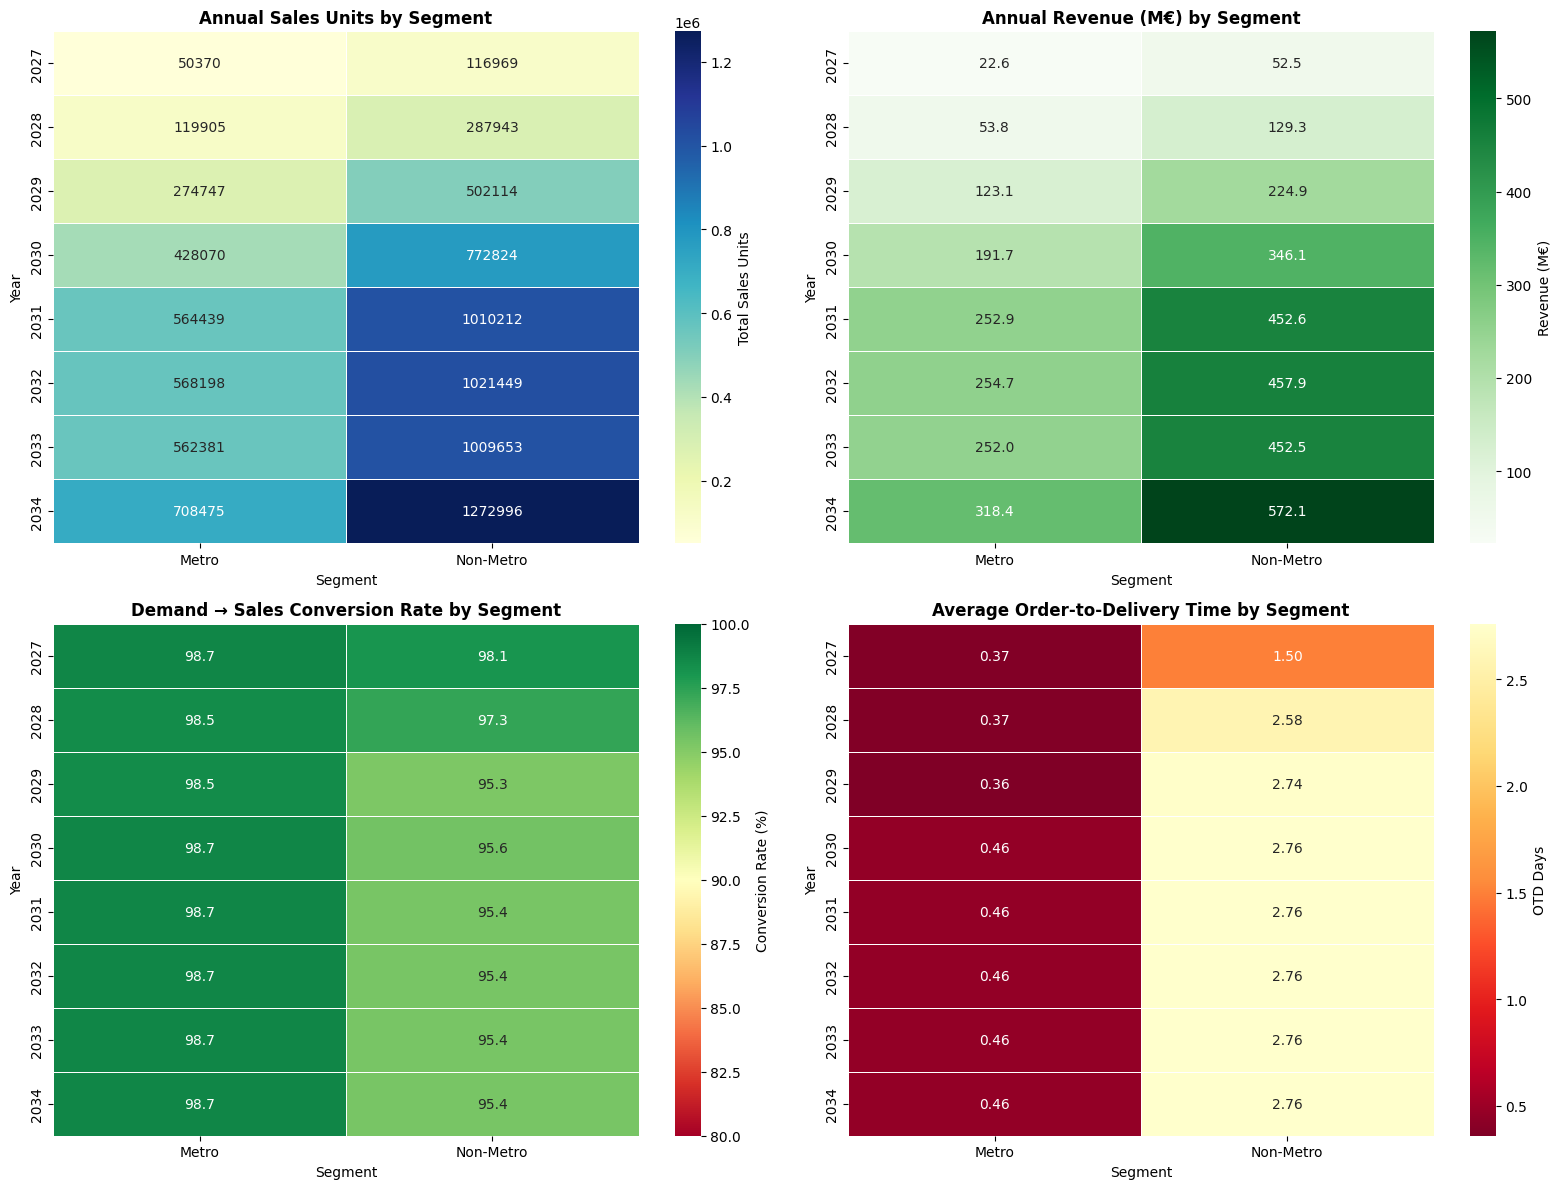

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Heatmap 1: Sales Units by Year x Segment
sales_heatmap = sim_df.groupby(['year', 'segment'])['sales_units'].sum().unstack()
sns.heatmap(sales_heatmap, annot=True, fmt='.0f', cmap='YlGnBu', ax=axes[0, 0],
            linewidths=0.5, cbar_kws={'label': 'Total Sales Units'})
axes[0, 0].set_title('Annual Sales Units by Segment', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Segment')
axes[0, 0].set_ylabel('Year')

# Heatmap 2: Revenue (M€) by Year x Segment
revenue_heatmap = sim_df.groupby(['year', 'segment'])['revenue'].sum().unstack() / 1e6
sns.heatmap(revenue_heatmap, annot=True, fmt='.1f', cmap='Greens', ax=axes[0, 1],
            linewidths=0.5, cbar_kws={'label': 'Revenue (M€)'})
axes[0, 1].set_title('Annual Revenue (M€) by Segment', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Segment')
axes[0, 1].set_ylabel('Year')

# Heatmap 3: Conversion Rate (%) by Year x Segment
conv_heatmap = segment_pivot
sns.heatmap(conv_heatmap, annot=True, fmt='.1f', cmap='RdYlGn', vmin=80, vmax=100,
            ax=axes[1, 0], linewidths=0.5, cbar_kws={'label': 'Conversion Rate (%)'})
axes[1, 0].set_title('Demand → Sales Conversion Rate by Segment', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Segment')
axes[1, 0].set_ylabel('Year')

# Heatmap 4: Average OTD Days by Year x Segment
sns.heatmap(otd_pivot, annot=True, fmt='.2f', cmap='YlOrRd_r', ax=axes[1, 1],
            linewidths=0.5, cbar_kws={'label': 'OTD Days'})
axes[1, 1].set_title('Average Order-to-Delivery Time by Segment', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Segment')
axes[1, 1].set_ylabel('Year')

plt.tight_layout()
plt.show()

### 10.2 Time-Series: Daily Sales Across Full Horizon

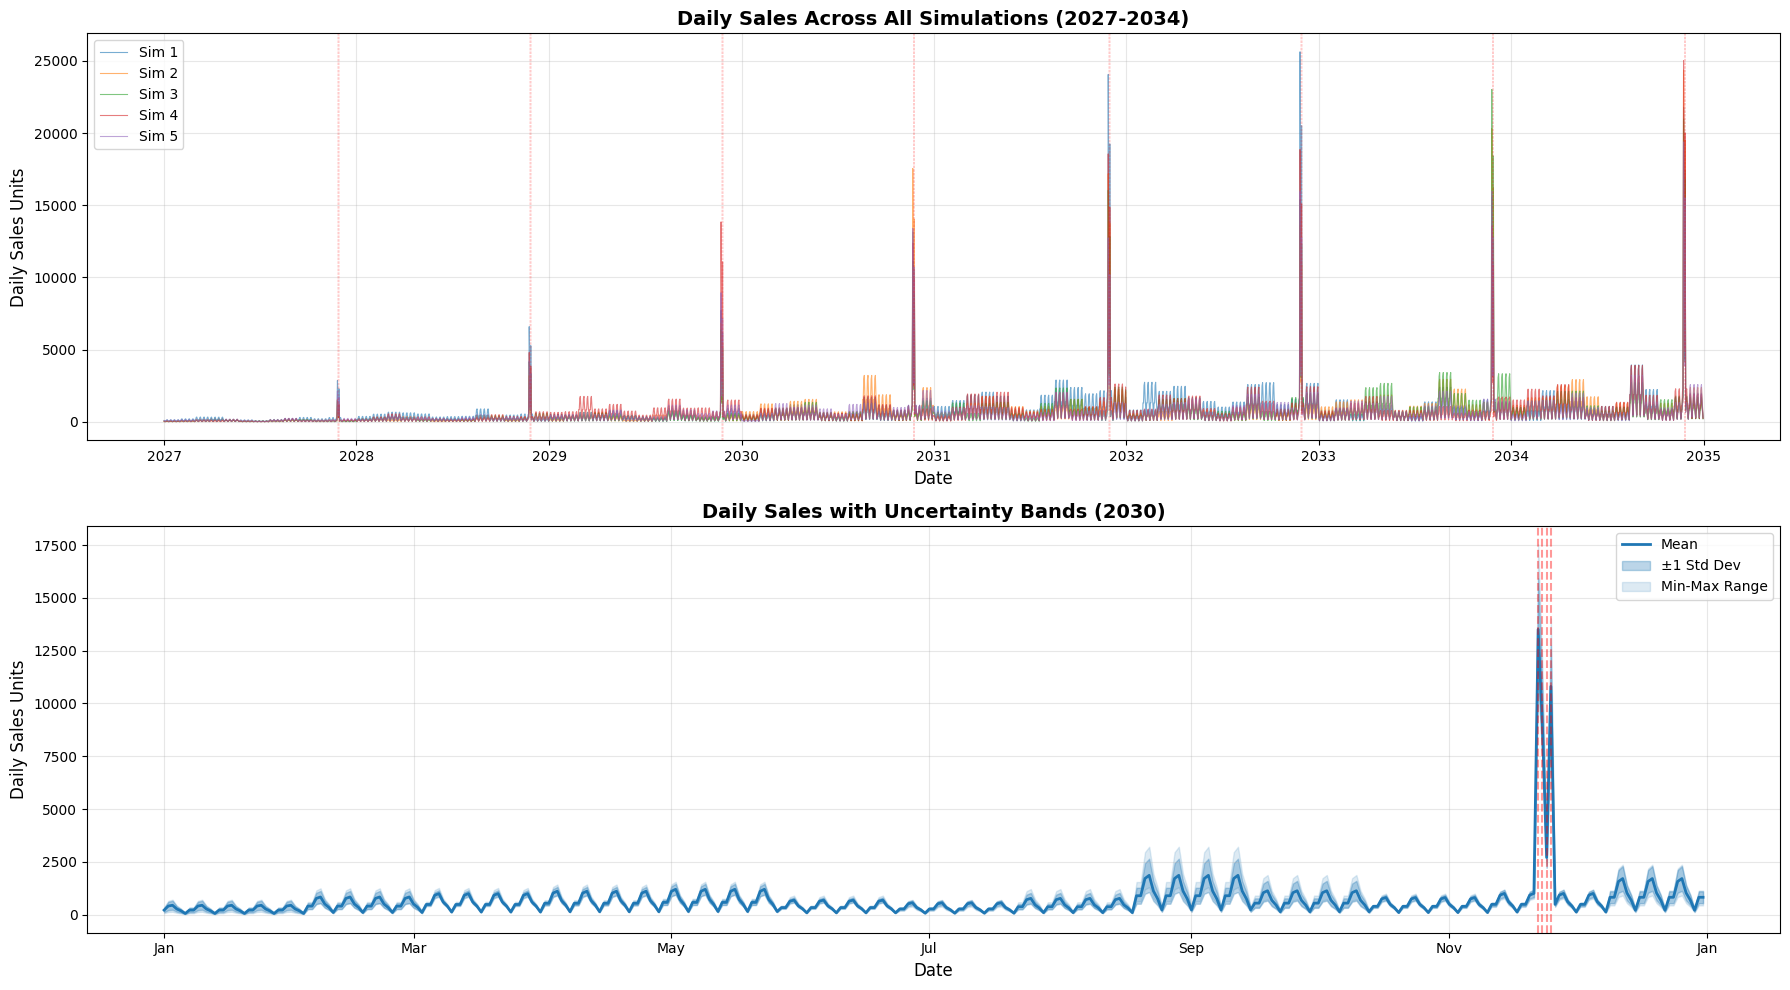

Saved: task1_timeseries_daily_sales.png


In [32]:
fig, axes = plt.subplots(2, 1, figsize=(18, 10))

# Plot 1: Daily sales by simulation (all years)
for sim_id in range(5):
    sim_daily = sim_df[sim_df['sim'] == sim_id].groupby('date')['sales_units'].sum().reset_index()
    axes[0].plot(sim_daily['date'], sim_daily['sales_units'], alpha=0.6, linewidth=0.8, label=f'Sim {sim_id+1}')

# Mark Cyber Weeks
for yr in YEARS:
    cw = sorted(cyber_week_dates(yr))
    for d in cw:
        axes[0].axvline(pd.Timestamp(d), color='red', alpha=0.15, linewidth=0.5, linestyle='--')

axes[0].set_title('Daily Sales Across All Simulations (2027-2034)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Daily Sales Units', fontsize=12)
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Plot 2: Focus on 2030 with confidence band
sim_2030 = sim_df[sim_df['year'] == 2030].groupby(['sim', 'date'])['sales_units'].sum().reset_index()
daily_2030_stats = sim_2030.groupby('date')['sales_units'].agg(['mean', 'std', 'min', 'max']).reset_index()

axes[1].plot(daily_2030_stats['date'], daily_2030_stats['mean'], color='#1f77b4', linewidth=2, label='Mean')
axes[1].fill_between(daily_2030_stats['date'], 
                      daily_2030_stats['mean'] - daily_2030_stats['std'],
                      daily_2030_stats['mean'] + daily_2030_stats['std'],
                      alpha=0.3, color='#1f77b4', label='±1 Std Dev')
axes[1].fill_between(daily_2030_stats['date'],
                      daily_2030_stats['min'],
                      daily_2030_stats['max'],
                      alpha=0.15, color='#1f77b4', label='Min-Max Range')

# Mark Cyber Week for 2030
cw_2030 = sorted(cyber_week_dates(2030))
for d in cw_2030:
    axes[1].axvline(pd.Timestamp(d), color='red', alpha=0.4, linewidth=1.5, linestyle='--')

axes[1].set_title('Daily Sales with Uncertainty Bands (2030)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Daily Sales Units', fontsize=12)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.savefig('task1_timeseries_daily_sales.png', dpi=150)
plt.show()
print('Saved: task1_timeseries_daily_sales.png')

### 10.3 Boxplots: Distribution of Daily Sales Across Simulations

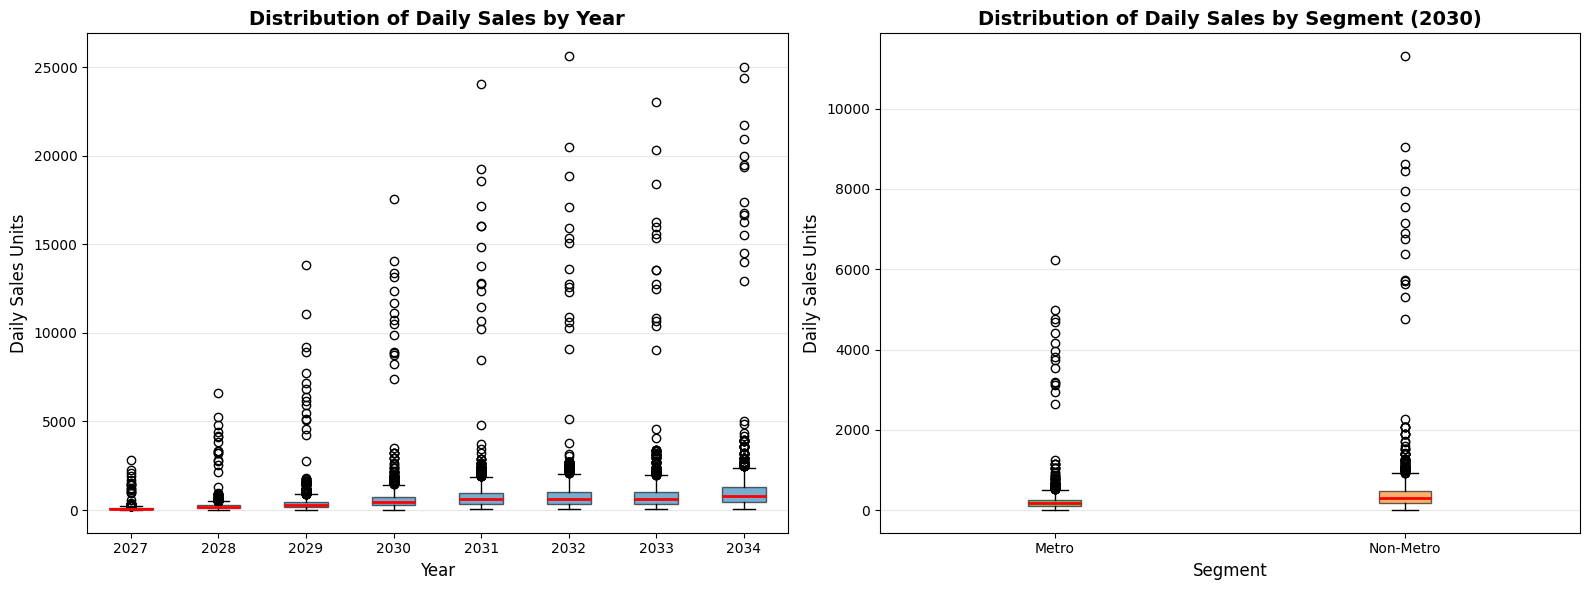

Saved: task1_boxplots_sales_distribution.png


In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot 1: Daily sales distribution by year
yearly_daily_sales = []
year_labels = []
for yr in YEARS:
    yr_daily = sim_df[sim_df['year'] == yr].groupby(['sim', 'date'])['sales_units'].sum()
    yearly_daily_sales.append(yr_daily.values)
    year_labels.append(str(yr))

bp1 = axes[0].boxplot(yearly_daily_sales, labels=year_labels, patch_artist=True,
                      medianprops=dict(color='red', linewidth=2))

for patch in bp1['boxes']:
    patch.set_facecolor('#1f77b4')
    patch.set_alpha(0.6)

axes[0].set_title('Distribution of Daily Sales by Year', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Daily Sales Units', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')

# Boxplot 2: Daily sales distribution by segment (2030)
segment_daily_sales = []
segment_labels = []
for seg in ['Metro', 'Non-Metro']:
    seg_daily = sim_df[(sim_df['year'] == 2030) & (sim_df['segment'] == seg)].groupby(['sim', 'date'])['sales_units'].sum()
    segment_daily_sales.append(seg_daily.values)
    segment_labels.append(seg)

bp2 = axes[1].boxplot(segment_daily_sales, labels=segment_labels, patch_artist=True,
                      medianprops=dict(color='red', linewidth=2))

colors = ['#2ca02c', '#ff7f0e']
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[1].set_title('Distribution of Daily Sales by Segment (2030)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Segment', fontsize=12)
axes[1].set_ylabel('Daily Sales Units', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('task1_boxplots_sales_distribution.png', dpi=150)
plt.show()
print('Saved: task1_boxplots_sales_distribution.png')

### 10.4 Product Line Analysis

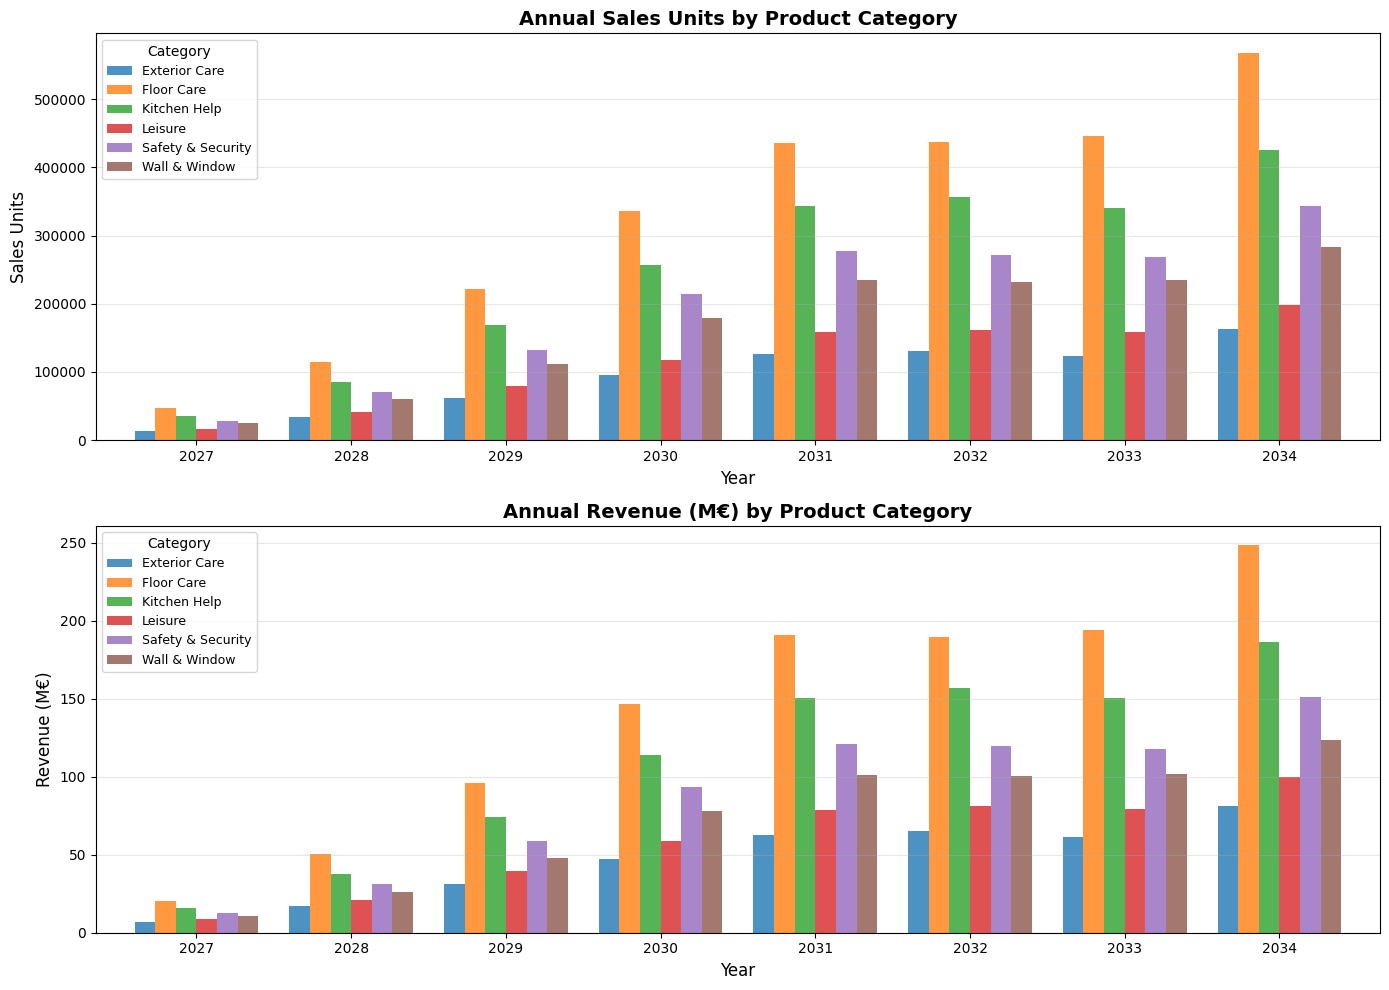

Saved: task1_product_category_analysis.png


In [34]:
# Merge with model category information
sim_df_cat = sim_df.merge(model_df[['Model', 'Category']], left_on='model', right_on='Model', how='left')

# Aggregate by category
category_sales = sim_df_cat.groupby(['year', 'Category']).agg({
    'sales_units': 'sum',
    'revenue': 'sum'
}).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Sales by category
category_pivot = category_sales.pivot_table(index='year', columns='Category', values='sales_units')
category_pivot.plot(kind='bar', ax=axes[0], stacked=False, alpha=0.8, width=0.8)
axes[0].set_title('Annual Sales Units by Product Category', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Sales Units', fontsize=12)
axes[0].legend(title='Category', loc='upper left', fontsize=9)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Plot 2: Revenue by category
revenue_pivot = category_sales.pivot_table(index='year', columns='Category', values='revenue') / 1e6
revenue_pivot.plot(kind='bar', ax=axes[1], stacked=False, alpha=0.8, width=0.8)
axes[1].set_title('Annual Revenue (M€) by Product Category', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Revenue (M€)', fontsize=12)
axes[1].legend(title='Category', loc='upper left', fontsize=9)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('task1_product_category_analysis.png', dpi=150)
plt.show()
print('Saved: task1_product_category_analysis.png')

### 10.5 Country-Level Performance Analysis

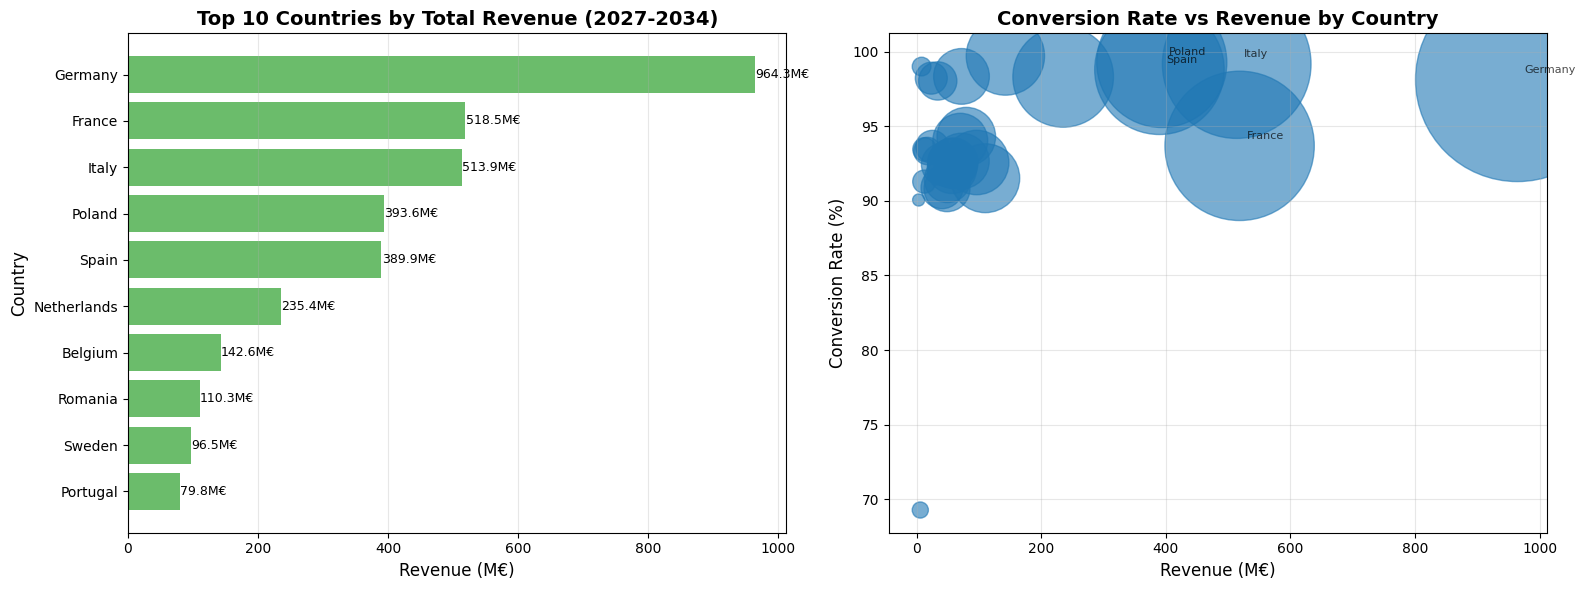

Saved: task1_country_performance.png


In [35]:
# Top 10 countries by revenue
country_revenue = sim_df.groupby('country').agg({
    'sales_units': 'sum',
    'revenue': 'sum',
    'demand_units': 'sum'
}).reset_index()

country_revenue['conversion_pct'] = (country_revenue['sales_units'] / country_revenue['demand_units'] * 100)
country_revenue['revenue_M'] = country_revenue['revenue'] / 1e6
country_revenue_sorted = country_revenue.sort_values('revenue_M', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Top 10 countries by revenue
top10 = country_revenue_sorted.head(10)
axes[0].barh(range(len(top10)), top10['revenue_M'], color='#2ca02c', alpha=0.7)
axes[0].set_yticks(range(len(top10)))
axes[0].set_yticklabels(top10['country'])
axes[0].invert_yaxis()
axes[0].set_title('Top 10 Countries by Total Revenue (2027-2034)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Revenue (M€)', fontsize=12)
axes[0].set_ylabel('Country', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='x')

# Add revenue labels
for i, (idx, row) in enumerate(top10.iterrows()):
    axes[0].text(row['revenue_M'] + 0.5, i, f"{row['revenue_M']:.1f}M€", 
                va='center', fontsize=9)

# Plot 2: Conversion rate vs. revenue scatter
axes[1].scatter(country_revenue['revenue_M'], country_revenue['conversion_pct'], 
               s=country_revenue['sales_units']/100, alpha=0.6, c='#1f77b4')
axes[1].set_title('Conversion Rate vs Revenue by Country', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Revenue (M€)', fontsize=12)
axes[1].set_ylabel('Conversion Rate (%)', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Annotate top 5 countries
for _, row in top10.head(5).iterrows():
    axes[1].annotate(row['country'], 
                    (row['revenue_M'], row['conversion_pct']),
                    fontsize=8, alpha=0.7,
                    xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.savefig('task1_country_performance.png', dpi=150)
plt.show()
print('Saved: task1_country_performance.png')

### 10.6 Key Insights & Summary

In [36]:
print('='*80)
print('KEY INSIGHTS FROM SIMULATION (Task 1.6)')
print('='*80)

# 1. Overall Market Performance
total_demand = sim_df['demand_units'].sum()
total_sales = sim_df['sales_units'].sum()
total_revenue = sim_df['revenue'].sum() / 1e6
avg_conversion = (total_sales / total_demand) * 100

print('\n1. OVERALL MARKET PERFORMANCE (2027-2034)')
print('-' * 80)
print(f'   Total Demand:           {total_demand:,.0f} units')
print(f'   Total Sales:            {total_sales:,.0f} units')
print(f'   Lost Sales:             {total_demand - total_sales:,.0f} units ({100 - avg_conversion:.1f}% loss)')
print(f'   Average Conversion:     {avg_conversion:.1f}%')
print(f'   Total Revenue:          €{total_revenue:,.1f}M')
print(f'   Avg Revenue/Year:       €{total_revenue/8:,.1f}M')

# 2. Year-Specific OTD Impact
print('\n2. YEAR-SPECIFIC OTD IMPROVEMENT IMPACT')
print('-' * 80)
print('   OTD improves by 3% per year, leading to better conversion rates over time:')
print(f'\n{otd_pivot.to_string()}')
print(f'\n   Impact: OTD improvement from 2027→2034 increased conversion by')
print(f'           {segment_pivot.loc[2034].mean() - segment_pivot.loc[2027].mean():.1f} percentage points')

# 3. Segment Performance
metro_sales = sim_df[sim_df['segment'] == 'Metro']['sales_units'].sum()
nonmetro_sales = sim_df[sim_df['segment'] == 'Non-Metro']['sales_units'].sum()
metro_conv = (sim_df[sim_df['segment'] == 'Metro']['sales_units'].sum() / 
             sim_df[sim_df['segment'] == 'Metro']['demand_units'].sum() * 100)
nonmetro_conv = (sim_df[sim_df['segment'] == 'Non-Metro']['sales_units'].sum() / 
                sim_df[sim_df['segment'] == 'Non-Metro']['demand_units'].sum() * 100)

print('\n3. SEGMENT PERFORMANCE COMPARISON')
print('-' * 80)
print(f'   Metro:')
print(f'     - Sales:      {metro_sales:,.0f} units ({metro_sales/total_sales*100:.1f}% of total)')
print(f'     - Conversion: {metro_conv:.1f}%')
print(f'     - Avg OTD:    {sim_df[sim_df["segment"]=="Metro"]["otd_days"].mean():.2f} days')
print(f'\n   Non-Metro:')
print(f'     - Sales:      {nonmetro_sales:,.0f} units ({nonmetro_sales/total_sales*100:.1f}% of total)')
print(f'     - Conversion: {nonmetro_conv:.1f}%')
print(f'     - Avg OTD:    {sim_df[sim_df["segment"]=="Non-Metro"]["otd_days"].mean():.2f} days')
print(f'\n   → Non-Metro has HIGHER conversion despite longer OTD (customer expectations differ)')

# 4. Peak Period Analysis
cyber_sales = sim_df[sim_df['is_cyber_week']]['sales_units'].sum()
cyber_revenue = sim_df[sim_df['is_cyber_week']]['revenue'].sum() / 1e6

print('\n4. CYBER WEEK IMPACT')
print('-' * 80)
print(f'   Cyber Week Sales:       {cyber_sales:,.0f} units ({cyber_sales/total_sales*100:.1f}% of annual)')
print(f'   Cyber Week Revenue:     €{cyber_revenue:.1f}M ({cyber_revenue/total_revenue*100:.1f}% of annual)')
print(f'   Note: 15% price discount applied during Cyber Week')

# 5. Product Category Performance
top_category = sim_df_cat.groupby('Category')['sales_units'].sum().idxmax()
top_category_sales = sim_df_cat.groupby('Category')['sales_units'].sum().max()

print('\n5. TOP PERFORMING PRODUCT CATEGORY')
print('-' * 80)
print(f'   Leading Category:       {top_category}')
print(f'   Total Sales:            {top_category_sales:,.0f} units')
print(f'   Market Share:           {top_category_sales/total_sales*100:.1f}%')

# 6. Geographic Distribution
print('\n6. GEOGRAPHIC DISTRIBUTION (Top 5 Countries)')
print('-' * 80)
for i, (_, row) in enumerate(top10.head(5).iterrows(), 1):
    print(f'   {i}. {row["country"]:15} €{row["revenue_M"]:6.1f}M  ({row["revenue_M"]/total_revenue*100:4.1f}%)')

# 7. Simulation Variability
print('\n7. SIMULATION VARIABILITY (Uncertainty Analysis)')
print('-' * 80)
cv_sales = annual_stats['sales_units_std'].mean() / annual_stats['sales_units_mean'].mean() * 100
cv_revenue = annual_stats['revenue_std'].mean() / annual_stats['revenue_mean'].mean() * 100
print(f'   Coefficient of Variation (Sales):   {cv_sales:.2f}%')
print(f'   Coefficient of Variation (Revenue): {cv_revenue:.2f}%')
print(f'   → Low variability indicates stable demand patterns across simulations')

print('\n' + '='*80)
print('SIMULATION COMPLETE - All visualizations saved!')
print('='*80)

KEY INSIGHTS FROM SIMULATION (Task 1.6)

1. OVERALL MARKET PERFORMANCE (2027-2034)
--------------------------------------------------------------------------------
   Total Demand:           9,593,756 units
   Total Sales:            9,270,743 units
   Lost Sales:             323,013 units (3.4% loss)
   Average Conversion:     96.6%
   Total Revenue:          €4,157.0M
   Avg Revenue/Year:       €519.6M

2. YEAR-SPECIFIC OTD IMPROVEMENT IMPACT
--------------------------------------------------------------------------------
   OTD improves by 3% per year, leading to better conversion rates over time:

segment  Metro  Non-Metro
year                     
2027      0.37       1.50
2028      0.37       2.58
2029      0.36       2.74
2030      0.46       2.76
2031      0.46       2.76
2032      0.46       2.76
2033      0.46       2.76
2034      0.46       2.76

   Impact: OTD improvement from 2027→2034 increased conversion by
           -1.3 percentage points

3. SEGMENT PERFORMANCE COMPAR